# Clustering and Classifying UK Westminster Constituencies

### Candiate: 097750


This project uses socioeconomic data from the House of Commons Library to cluster and classifiy similar UK Parlimentary constituencies. I became interested in Politics after reading "Prisoners of Geography" by Tim Marshall this summer. To cast an educated vote in the 2019 election I found myself carrying out a lot of research into the policies suggested by each party which is how I came across the data used in this project. I found this project extremely satisfying and the results were better than I had initially hoped. Discovering the Geopandas library made the data visualization extremely easy and provided some great graphics. 

###### All of the code below should run.

## Installing requried libraries

* Geopandas is a library built on the Pandas framework. It allows a 'geometry' attribute to be held and manipulated and is used for creating the constituency map of the UK

In [1]:
conda install geopandas

SyntaxError: invalid syntax (<ipython-input-1-c89509c9cc5c>, line 1)

* Descartes is a plotting package, used to plot the constituency map

In [2]:
conda install descartes

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


* rfpimp is a package used to rank feature importance in the random forest

In [3]:
pip install rfpimp

Note: you may need to restart the kernel to use updated packages.


## Importing the required modules

In [5]:
#import geopandas
import descartes
from descartes import PolygonPatch
from sklearn import preprocessing
import matplotlib as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import random
#from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import AffinityPropagation
from sklearn.metrics import confusion_matrix
import seaborn
from sklearn.ensemble import AdaBoostClassifier
%matplotlib inline

# <font color='red'>Important: Select to classify using 2017 Result labels or 2019 Result Labels here!</font> 

This will only change the result labels used for classification, raw data doesn't change. This will only impact classification, not clustering.

In [3]:
year = "2017"

## Importing Data Required for Clustering

#### Map data was taken from:
https://martinjc.github.io/UK-GeoJSON/

In [6]:
#Reading in the UK Map File
ukmap = geopandas.read_file('map.json')

In [6]:
#Reading in the Constituency Data from CSV.
#The CSV was compiled from House of Commons Data
df = pd.read_csv("ConstituencyDataEngland.csv", sep=",", header=None)

#Reading in the Brexit vote data from CSV
brexit = pd.read_csv("Brexit.csv", sep=",", header=None)

## Pre-Processing for Clustering

In [8]:
#Merging the Brexit and Constituency Data
df = pd.merge(df, brexit, on=0)

#Setting column names
df = df.rename(columns={"1_y": "Brexit", 0: "Constituencies", "1_x": "HousePrices", 2: "Wage",3: "British",4: "Tenure",5: "School Grades", 6:"0-9",7:"10-19",8:"20-29",9:"30-39",10:"40-49",11:"50-59",12:"60-69",13:"70-79",14:"80+",15:"Voted Leave"})
df = df[1:] #take the data less the header row

#Removing Constituency Column in prep for clustering
unscaled = df.drop(columns="Constituencies")

#Scaling the data so all attributes are weighted equally

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(unscaled.values)
scaled_values = pd.DataFrame(x_scaled)
mat = scaled_values.values

## KMeans Clustering + Davis Bouldin

best number of clusters is 6


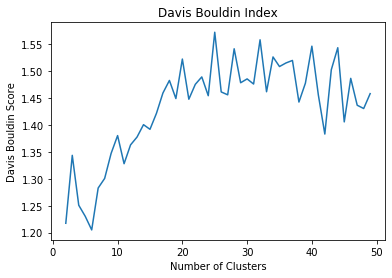

In [9]:
#Used to plot Davis-Bouldin index
davis_bouldin_index = []
x_axis = []

#iterating over different numbers of clusters to determine the optimal.
for i in range(2,50):
    x_axis.append(i)
    #Applying the Kmeans clustering algorithm
    
    km = KMeans(n_clusters=i, random_state=0).fit(mat)
    labels = km.labels_
    results = pd.DataFrame([scaled_values.index,labels]).T
    #Inserting the labels into the original dataframe
    davis_bouldin_index.append(davies_bouldin_score(scaled_values, labels))   
plt.plot(x_axis, davis_bouldin_index)
plt.title("Davis Bouldin Index")
plt.ylabel("Davis Bouldin Score")
plt.xlabel("Number of Clusters")


#Finding the optimal number of clusters from the Davis-Bouldin Index
km = KMeans(n_clusters=32, random_state=0).fit(mat)
labels = km.labels_
print("best number of clusters is " + str(davis_bouldin_index.index(min(davis_bouldin_index))+2))

  
#Inserting kmeans labels into the dataframe
df.insert(0, "kmeans", labels)

## Affinity Propagation Clustering

In [10]:
af = AffinityPropagation().fit(scaled_values)
cluster_centers_indices = af.cluster_centers_indices_
affinitylabels = af.labels_

#Number of clusters determined by the Preference parameter.
#This parameter sets how strongly each datapoint thinks it is an examplar

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)

#Inserting the affinitypropagation data into the dataframe
df.insert(0, "affinity", affinitylabels)

Estimated number of clusters: 32


## Plotting Clusters

Text(0.5, 1, 'UK Map, Affinity Clustered by Socioeconomic Factors')

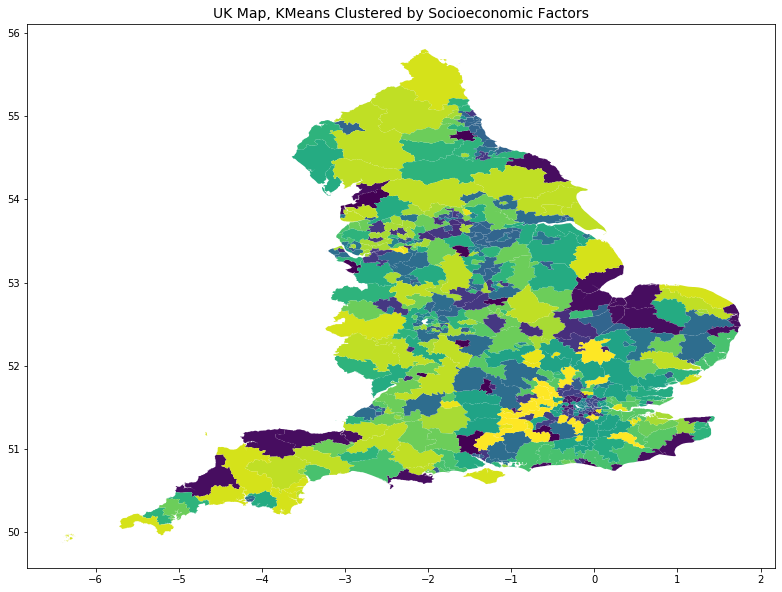

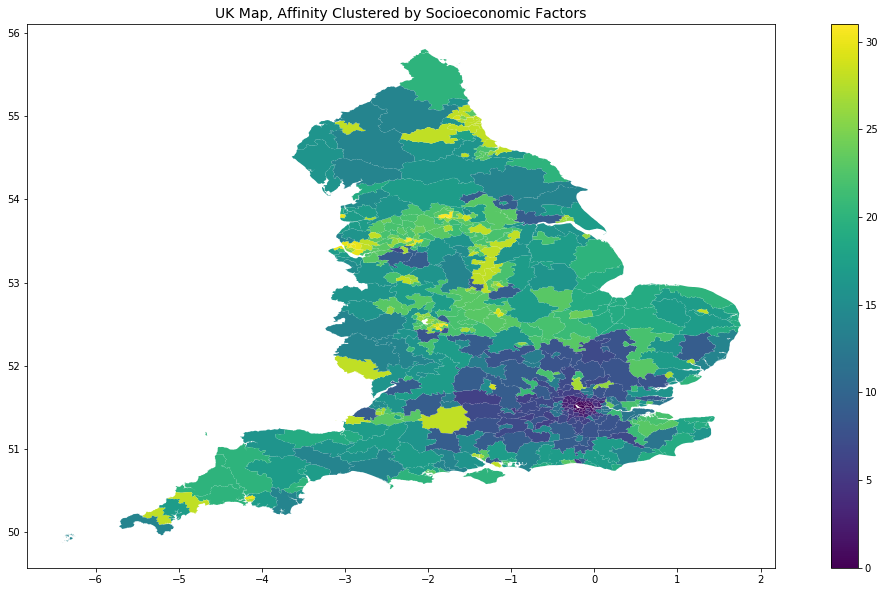

In [11]:
#Renaming map column so it can be merged with original dataframe
ukmap = ukmap.rename(columns={'PCON13NM': "Constituencies"})

#creating master dataframe containing all clustering information, geographic information and column headers. 
master = pd.merge(ukmap, df, on="Constituencies")


#PLotting UK Map, colour coded by Kmeans clusters
master.plot(column='kmeans', figsize=(20,10), legend=False)
plt.title("UK Map, KMeans Clustered by Socioeconomic Factors", fontsize=14)

#Plotting UK Map, colour coded by Affinity Propagation clusters
master.plot(column='affinity', figsize=(20,10), legend=True)
plt.title("UK Map, Affinity Clustered by Socioeconomic Factors", fontsize=14)

## Importing Data for Classification

In [12]:
results2017 = pd.read_csv("2017Results.csv", sep=",", header=None)
results2017 = results2017.rename(columns={0: "Constituencies", 1: "Party"})

In [13]:
results2019 = pd.read_csv("2019Results.csv", sep=",", header=None)
results2019 = results2019.rename(columns={0: "Constituencies", 1: "Party"})
master = pd.merge(master, results2017, on="Constituencies")
master = pd.merge(master, results2019, on="Constituencies")
pd.set_option('display.max_rows', None)
master = master.rename(columns={"Party_x": "result2017", "Party_y": "result2019"})

## Preprocessing for Classification

In [14]:
le = preprocessing.LabelEncoder()

master['result2017'] = le.fit_transform(master.result2017.values)
master['result2019'] = le.fit_transform(master.result2019.values)

#A random variable is used here to determine which variables are more important than random. Take this line 
# out to increase accuracy. You will also need to remove "Random" from toprow list two cells down.
randomlist = []
for _ in range(master.shape[0]):
    randomlist.append(random.random())
master.insert(0,"Random",randomlist)

## Chosing Test Data

In [15]:
#Using sklearn to generte a train/test split
train, test = train_test_split(master, test_size=0.2)
year_to_use = "result" + str(year)
train_ys = train[year_to_use]
#Removing unnecessary columns from the training X data

original_training_data = train
original_test_data = test
train = train.drop(columns=['id', 'PCON13CD', 'PCON13CDO', 'Constituencies', 'geometry', 'kmeans', 'affinity', 'result2017', 'result2019'])

test_ys = test[year_to_use]
test_ys=test_ys.to_numpy()

#Removing unnecessary columns from the X test data
test = test.drop(columns=['id', 'PCON13CD', 'PCON13CDO', 'Constituencies', 'geometry', 'kmeans', 'affinity', 'result2017', 'result2019'])

## Using Decision Tree Classifier + Feature Importances

Decision tree classifier got training seats to accuracy 1.0
Decision tree classifier predicted seats in test data with accuracy 0.794392523364486


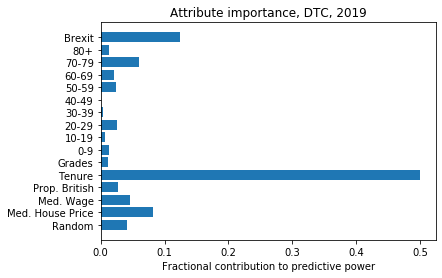

In [16]:
#Decision tree classifier
DTC = tree.DecisionTreeClassifier()
DTC = DTC.fit(train, train_ys)
trainpredictions = DTC.predict(train)
testpredictions = DTC.predict(test) 

print("Decision tree classifier got training seats to accuracy " + str(accuracy_score(trainpredictions, train_ys)))
print("Decision tree classifier predicted seats in test data with accuracy " + str(accuracy_score(testpredictions,test_ys)))
toprow = ["Random", "Med. House Price", "Med. Wage", "Prop. British", "Tenure", "Grades", "0-9", "10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "70-79", "80+", "Brexit"]
plt.barh(toprow, DTC.feature_importances_)
plt.title("Attribute importance, DTC, " + str(year))
plt.xlabel("Fractional contribution to predictive power")
plt.show()

## DTC Confusion Matrix heatmap

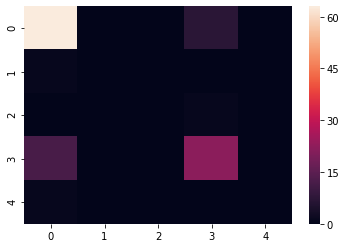

In [17]:
#Producing a confusion Matrix for the Decision Tree
CM_DTC = confusion_matrix(testpredictions, test_ys)
# Visualize it as a heatmap
seaborn.heatmap(CM_DTC)

##Using 2017 data:
## 1 = Tory
## 2 = LD
## 3 = Lab
## 4 = Other


##Using 2019 data:
## 1 = Tory
## 2 = LD
## 3 = Lab
## 4 = Other

## Random Forest + Feature Importances

In [18]:
# Initiating a Random Forest Classifier
RF = RandomForestClassifier(n_estimators=1000)

#Fitting the Classifier to the training Data
RF.fit(train,train_ys)

#Using the model to classify training data
y_train_predictions = RF.predict(train)

#Using the model to classify test data
y_predictions = RF.predict(test)
print("Got training data accuracy of " + str(accuracy_score(y_train_predictions,train_ys)))
print("Random forest achieved prediction accuracy" + str(accuracy_score(y_predictions, test_ys)))


#Inserting the labels back into the training and test data dataframes
original_training_data.insert(10,"RandomForest",y_train_predictions)
original_test_data.insert(10,"RandomForest",y_predictions)

Got training data accuracy of 1.0
Random forest achieved prediction accuracy0.8785046728971962


## Random Forest Confusion Matrix heatmap

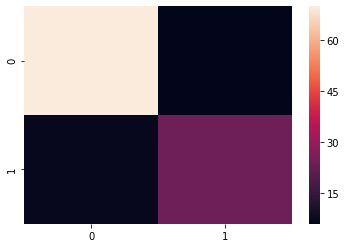

In [19]:
#Plotting a confusion matrix heatmap for the Random Forest
#Shape is sometimes 2x2, 3x3, 4x4 depending on samples in training data

CM_RF = confusion_matrix(y_predictions, test_ys)
# Visualize it as a heatmap
seaborn.heatmap(CM_RF)
plt.show()

## Recombining dataframes to plot classification map

In [20]:
# Merging the training data and the test data with the master dataframe so that the geometry data can be used with the labels 
# to generate plots.

# As left merges have been used the two dataframes then must be appended so as not to lose any data. 

df1 = pd.merge(master,original_training_data[['Constituencies','RandomForest']],on='Constituencies')
df2 = pd.merge(master,original_test_data[['Constituencies','RandomForest']],on='Constituencies')
master = df1.append(df2) #df3 is a dataframe containing all the information that has accumulated so far

## Plotting Classification Map and Result Map
##### When these were included in the report, they were colour corrected in Photoshop to the tradition party colours

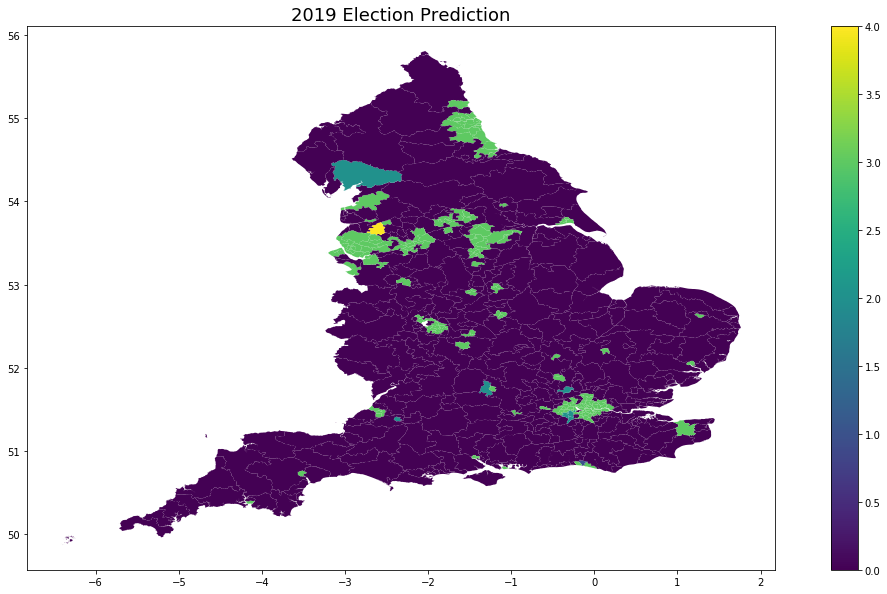

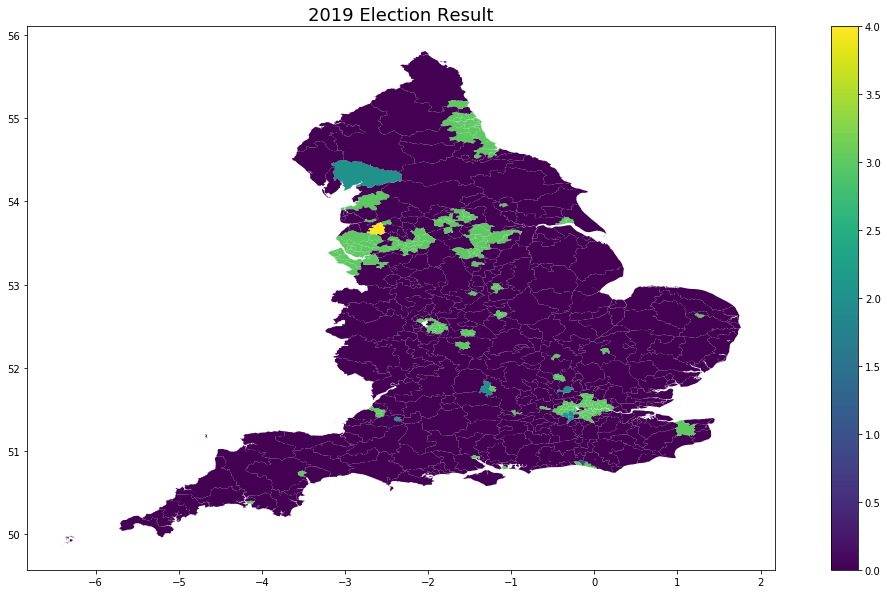

In [21]:
# Plotting the Random Forest Classifications and the Actual Results
master.plot(column='RandomForest', figsize=(20,10), legend=True)
plt.title(str(year) + " Election Prediction", fontsize=18)
master.plot(column=year_to_use, figsize=(20,10),legend=True)
plt.title(str(year) + " Election Result", fontsize=18)


#Working out which constituencies have been incorrectly classified.
missclassified = []
resultpredictions = master['RandomForest'].values
result = master[year_to_use].values
for i in range(master.shape[0]):
    if(resultpredictions[i] == result[i]):
        missclassified.append(1)
    else:
        missclassified.append(0)
master.insert(0,"AccuratePrediction", missclassified)



##Using 2017 data:
## 1 = Tory
## 2 = LD
## 3 = Lab
## 4 = John Bercow, Speaker of the House


##Using 2019 data:
## 1 = Tory
## 2 = LD
## 3 = Lab
## 4 = Chorley Constituency, Speaker of the House

## Displaying inccorectly classified Constituencies

Incorrectly classified constituencies were:
Cities of London and Westminster
Coventry North West
Denton and Reddish
Derby North
Ellesmere Port and Neston
Hendon
Ipswich
Leigh
Newcastle-under-Lyme
Sheffield, Hallam
Wirral South
Wolverhampton North East
Worsley and Eccles South


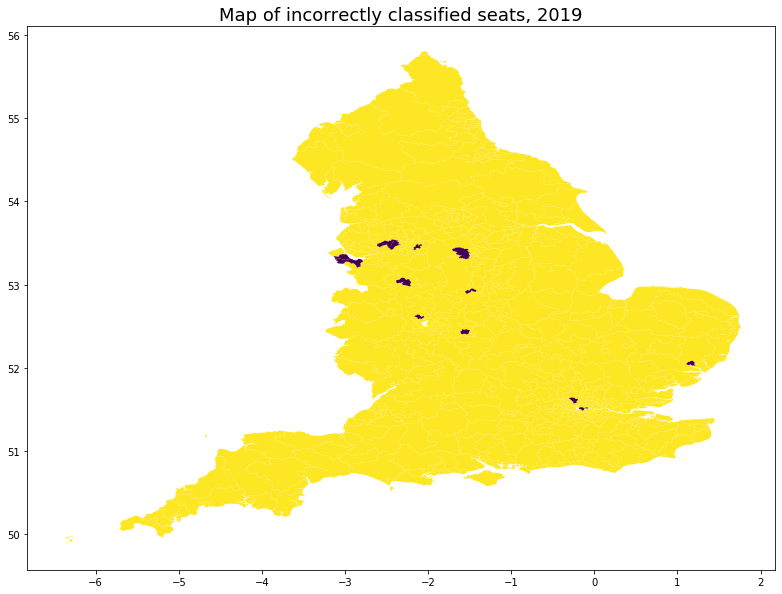

In [22]:
#Printing out which constituencies have been missclassified.

constituencylist = master['Constituencies'].values
partylist = master[year_to_use].values
      
print("Incorrectly classified constituencies were:")
for i in range(len(constituencylist)):
    if(missclassified[i]==0):
        print(constituencylist[i])

        
# Plot to highlight which constituencies have been missclassified
master.plot(column='AccuratePrediction', figsize=(20,10))
plt.title("Map of incorrectly classified seats, " + str(year), fontsize=18)
plt.show()

## Determining Random Forest attribute importances

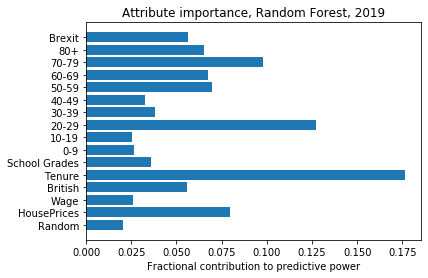

In [23]:
#Plotting the importances of each attribute
importances = RF.feature_importances_
plt.barh(train.columns, importances)
plt.title("Attribute importance, Random Forest, " + str(year))
plt.xlabel("Fractional contribution to predictive power")
plt.show()

## AdaBoost

0.8317757009345794


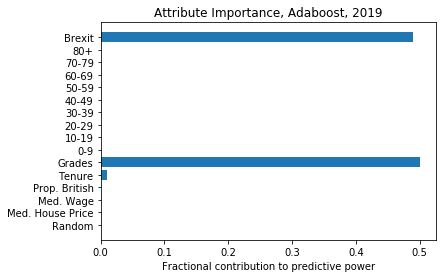

In [24]:
ada = AdaBoostClassifier(n_estimators=100)
ada.fit(train,train_ys)
y_predictions_boosted = ada.predict(test)
print(accuracy_score(y_predictions_boosted,test_ys))
plt.barh(toprow, ada.feature_importances_)
plt.title("Attribute Importance, Adaboost, " + str(year))
plt.xlabel("Fractional contribution to predictive power")
plt.show()